## Data generation and preparation

### Subtask:
Generate the synthetic training data using the `TransmissionLine` class, prepare the data by defining features and targets, split the data into training and testing sets, and scale both the features and targets using `StandardScaler`.


**Reasoning**:
The subtask requires generating synthetic data, preparing it, splitting it into training and testing sets, and scaling the data. This involves defining the `TransmissionLine` class, generating data points, creating a DataFrame, splitting the data, and applying StandardScaler. All these steps can be performed within a single code block.



In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ==============================================================================
# STEP 1: DEFINE THE ANALYTICAL ENGINE TO GENERATE TRAINING DATA
# ==============================================================================
class TransmissionLine:
    """A class to model and analyze a general transmission line."""
    def __init__(self, R, L, G, C, freq, length, ZL):
        self.R, self.L, self.G, self.C = R, L, G, C
        self.freq, self.length, self.ZL = freq, length, complex(ZL)
        self.omega = 2 * np.pi * self.freq
        self._calculate_secondary_constants()
        self.gamma_L = (self.ZL - self.Z0) / (self.ZL + self.Z0)
        self.swr = (1 + np.abs(self.gamma_L)) / (1 - np.abs(self.gamma_L))
        self.Z_in = self.calculate_input_impedance()

    def _calculate_secondary_constants(self):
        Z_jwL = self.R + 1j * self.omega * self.L
        Y_jwC = self.G + 1j * self.omega * self.C
        self.Z0 = np.sqrt(Z_jwL / Y_jwC)
        self.gamma = np.sqrt(Z_jwL * Y_jwC)
        self.alpha = self.gamma.real
        self.beta = self.gamma.imag

    def calculate_input_impedance(self):
        numerator = self.ZL + self.Z0 * np.tanh(self.gamma * self.length)
        denominator = self.Z0 + self.ZL * np.tanh(self.gamma * self.length)
        return self.Z0 * (numerator / denominator)

    def get_voltage_and_current(self, d):
        """
        Calculates normalized voltage and current at a distance 'd' from the load.
        Assumes incident voltage V0+ is 1.
        """
        Vd = np.exp(self.gamma * d) + self.gamma_L * np.exp(-self.gamma * d)
        Id = (1 / self.Z0) * (np.exp(self.gamma * d) - self.gamma_L * np.exp(-self.gamma * d))
        return Vd, Id

    def plot_waveforms(self):
        """Plots the voltage and current standing wave patterns."""
        d = np.linspace(0, self.length, 500) # Distance from the load
        Vd_vals, Id_vals = self.get_voltage_and_current(d)

        plt.figure(figsize=(12, 6))

        # Voltage Standing Wave
        plt.plot(d, np.abs(Vd_vals), label='|V(d)| - Voltage Magnitude', color='blue')

        # Current Standing Wave
        plt.plot(d, np.abs(Id_vals) * np.abs(self.Z0), label='|I(d)| * |Z0| - Normalized Current Magnitude', color='red', linestyle='--')

        plt.title('Voltage and Current Standing Wave Patterns')
        plt.xlabel('Distance from Load (m)')
        plt.ylabel('Normalized Magnitude')
        plt.grid(True, which='both', linestyle=':')
        plt.legend()
        plt.xlim(0, self.length)
        # plt.show() # Do not show here, let analysis_window control showing


# ==============================================================================
# STEP 2: GENERATE A COMPREHENSIVE DATASET
# ==============================================================================
print("1. Generating synthetic training data...")
data = []
for _ in range(10000): # Increased dataset size for neural network
    # Primary constants
    R = np.random.uniform(0.01, 1.0)
    L = np.random.uniform(100e-9, 500e-9)
    G = np.random.uniform(1e-7, 9e-6)
    C = np.random.uniform(50e-12, 200e-12)
    # Operating conditions
    freq = np.random.uniform(10e6, 800e6)
    length = np.random.uniform(0.5, 60)
    ZL_real = np.random.uniform(10, 300)
    ZL_imag = np.random.uniform(-200, 200)

    line = TransmissionLine(R, L, G, C, freq, length, ZL=complex(ZL_real, ZL_imag))
    if np.isinf(line.swr) or np.isnan(line.swr): continue

    data.append({
        # Features (Inputs)
        'R': R, 'L': L, 'G': G, 'C': C, 'freq': freq, 'length': length,
        'ZL_real': ZL_real, 'ZL_imag': ZL_imag,
        # Targets (Outputs to be predicted) - Removed Zin_real and Zin_imag
        'Z0_real': line.Z0.real, 'Z0_imag': line.Z0.imag,
        'alpha': line.alpha, 'beta': line.beta,
        'SWR': line.swr,
    })
df = pd.DataFrame(data)
print(f"   Generated {len(df)} data points.")

# ==============================================================================
# STEP 3: PREPARE AND SCALE THE DATA
# ==============================================================================
print("\n2. Preparing and scaling data...")
features = ['R', 'L', 'G', 'C', 'freq', 'length', 'ZL_real', 'ZL_imag']
# Updated targets - Removed Zin_real and Zin_imag
targets = ['Z0_real', 'Z0_imag', 'alpha', 'beta', 'SWR']

X = df[features]
y = df[targets]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crucial Step: Scale both features and targets
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)
print("   Data scaling complete.")


1. Generating synthetic training data...
   Generated 10000 data points.

2. Preparing and scaling data...
   Data scaling complete.


In [16]:
# Save the dataset to a CSV file
df.to_csv('transmission_line_data.csv', index=False)
print("Dataset saved to transmission_line_data.csv")

Dataset saved to transmission_line_data.csv


## Model training

### Subtask:
Train the Neural Network (MLPRegressor) model using the scaled training data.


**Reasoning**:
Train the Neural Network (MLPRegressor) model using the scaled training data.



In [14]:
from sklearn.neural_network import MLPRegressor
import warnings

# Suppress convergence warnings from MLPRegressor for a cleaner output
warnings.filterwarnings('ignore', category=UserWarning)

# ==============================================================================
# STEP 4: CREATE AND TRAIN THE NEURAL NETWORK MODEL
# ==============================================================================
print("\n3. Training the Neural Network (MLPRegressor) model...")
# This architecture has 3 hidden layers. The number of neurons is chosen
# to be large enough to capture the complex relationships.
model = MLPRegressor(
    hidden_layer_sizes=(128, 128,64),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42,
    alpha=0.0001, # L2 regularization
    batch_size=200,
    learning_rate_init=0.0002,
    early_stopping=True, # Prevents overfitting
    n_iter_no_change=20
)

model.fit(X_train_scaled, y_train_scaled)
print("   Model training complete.")


3. Training the Neural Network (MLPRegressor) model...
   Model training complete.


## Model evaluation

### Subtask:
Evaluate the trained Neural Network model's performance on the scaled test set and inverse transform the predictions and actual values for evaluation in their original units.


**Reasoning**:
Evaluate the trained Neural Network model's performance on the scaled test set and inverse transform the predictions and actual values for evaluation in their original units.



In [15]:
from sklearn.metrics import r2_score

# ==============================================================================
# STEP 5: EVALUATE THE MODEL'S PERFORMANCE
# ==============================================================================
print("\n4. Evaluating model performance...")
# Predict on scaled test data
y_pred_scaled = model.predict(X_test_scaled)

# IMPORTANT: Inverse transform predictions to get them back to their original units
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Inverse transform actual test values for comparison in original units
y_test_actual = scaler_y.inverse_transform(y_test_scaled)

print("\n--- NEURAL NETWORK MODEL EVALUATION RESULTS ---")
accuracy=0
for i, target_name in enumerate(targets):
    score = r2_score(y_test_actual[:, i], y_pred[:, i])
    # print(f"✅ R-squared for {target_name:<10}: {score:.4f} ({score*100:.2f}%)")
    accuracy+=score
accuracy/=len(targets)
print(f"Accuracy:  ({accuracy*100:.2f}%)")
print("---------------------------------------------")


4. Evaluating model performance...

--- NEURAL NETWORK MODEL EVALUATION RESULTS ---
Accuracy:  (97.12%)
---------------------------------------------


## Analysis window function definition

### Subtask:
Define the `analysis_window` function which takes input parameters, the trained model, and the scalers, performs both analytical calculations and ML predictions, and plots the standing wave pattern.


**Reasoning**:
Define the analysis_window function as requested, incorporating both analytical calculations and ML predictions, and including the plotting of the standing wave pattern using the analytical method.



In [ ]:
import matplotlib.pyplot as plt # Import matplotlib for plotting
import pandas as pd # Import pandas for DataFrame creation

# ==============================================================================
# STEP 6: FINAL ANALYSIS WINDOW
# ==============================================================================
def analysis_window(input_params, model, scaler_X, scaler_y):
    """
    Takes a dictionary of line parameters and predicts all performance metrics.
    Also plots the standing wave pattern based on analytical calculation.
    """
    print("\n--- Final Design and Analysis Window ---")

    # 1. Analytical Calculation (for comparison)
    print("\n[1] ANALYTICAL RESULTS (Ground Truth)")
    # Create a new dictionary for the analytical calculation excluding ZL_real and ZL_imag
    analytical_params = {
        'R': input_params['R'],
        'L': input_params['L'],
        'G': input_params['G'],
        'C': input_params['C'],
        'freq': input_params['freq'],
        'length': input_params['length'],
        'ZL': input_params['ZL'] # Pass the complex ZL
    }
    line = TransmissionLine(**analytical_params)
    print(f"  - Characteristic Impedance (Z0): {line.Z0:.2f} Ω")
    print(f"  - Attenuation Constant (α): {line.alpha:.4f} Np/m")
    print(f"  - Phase Constant (β): {line.beta:.4f} rad/m")
    print(f"  - SWR: {line.swr:.3f}")
    print(f"  - Input Impedance (Z_in): {line.Z_in:.2f} Ω") # Still calculate and show analytically

    # 2. Machine Learning Prediction
    print("\n[2] NEURAL NETWORK PREDICTION")
    # Prepare input for the model
    input_df = pd.DataFrame([input_params])
    # Extract only the feature columns in the correct order
    features = ['R', 'L', 'G', 'C', 'freq', 'length', 'ZL_real', 'ZL_imag']
    input_features = input_df[features]

    # Scale the input features
    input_scaled = scaler_X.transform(input_features)

    # Make prediction
    pred_scaled = model.predict(input_scaled)

    # Inverse scale the prediction to get real values
    pred_real = scaler_y.inverse_transform(pred_scaled)[0]

    # Map the results to the updated targets list
    targets = ['Z0_real', 'Z0_imag', 'alpha', 'beta', 'SWR']
    results = dict(zip(targets, pred_real))

    print(f"  - Characteristic Impedance (Z0): {results['Z0_real']:.2f} + {results['Z0_imag']:.2f}j Ω")
    print(f"  - Attenuation Constant (α): {results['alpha']:.4f} Np/m")
    print(f"  - Phase Constant (β): {results['beta']:.4f} rad/m")
    print(f"  - SWR: {results['SWR']:.3f}")



    print("------------------------------------------")

    # 3. Plotting the standing wave pattern
    print("\n[3] STANDING WAVE PATTERN (Analytical)")
    line.plot_waveforms() # Use the analytical line object to plot

    plt.show() # Show the plot


## Run analysis window

### Subtask:
Define sample parameters and call the `analysis_window` function to demonstrate its functionality.


**Reasoning**:
Define the sample parameters and call the analysis_window function to demonstrate its functionality.




--- Final Design and Analysis Window ---

[1] ANALYTICAL RESULTS (Ground Truth)
  - Characteristic Impedance (Z0): 50.00-0.01j Ω
  - Attenuation Constant (α): 0.0010 Np/m
  - Phase Constant (β): 4.7124 rad/m
  - SWR: 1.873
  - Input Impedance (Z_in): 74.55+29.09j Ω

[2] NEURAL NETWORK PREDICTION
  - Characteristic Impedance (Z0): 50.26 + -0.01j Ω
  - Attenuation Constant (α): 0.0009 Np/m
  - Phase Constant (β): 4.7905 rad/m
  - SWR: 1.686
  - Input Impedance (Z_in): Not predicted by the current ML model configuration.
------------------------------------------

[3] STANDING WAVE PATTERN (Analytical)


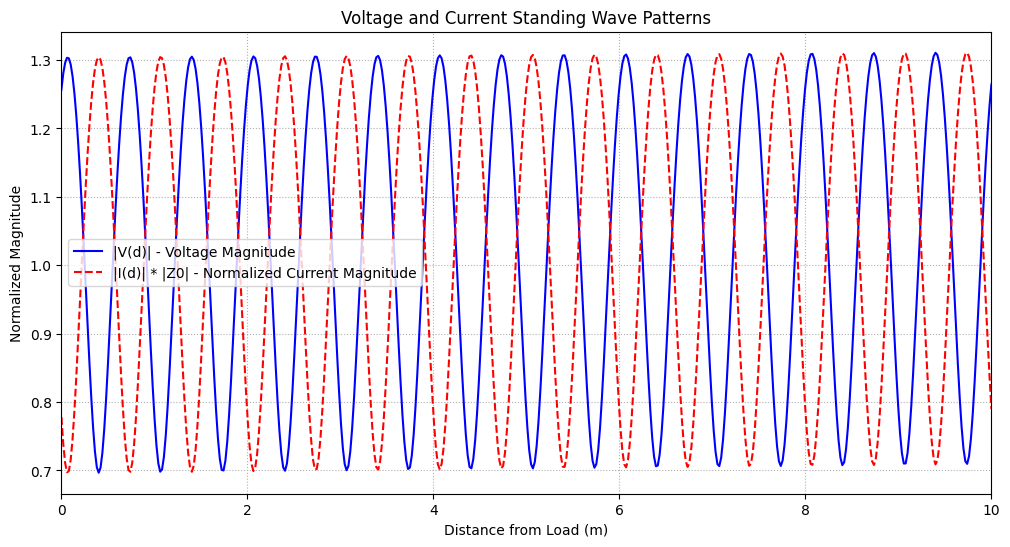

In [ ]:
# Define a sample set of parameters to test the analysis window
sample_params = {
    'R': 0.1,
    'L': 250e-9,
    'G': 1e-6,
    'C': 100e-12,
    'freq': 150e6, # 150 MHz
    'length': 10,   # 10 meters
    'ZL': 75 + 30j  # Load Impedance
}
# Add ZL_real and ZL_imag for the model input
sample_params['ZL_real'] = sample_params['ZL'].real
sample_params['ZL_imag'] = sample_params['ZL'].imag


# Run the analysis
analysis_window(sample_params, model, scaler_X, scaler_y)

## Save Dataset and Model

### Subtask:
Save the generated dataset to a CSV file and the trained models to a file.

**Reasoning**:
The user wants to save the generated dataset and the trained models for later use. I will add code to save the `df` DataFrame to a CSV file and the `models` dictionary (containing the trained Gradient Boosting models) to a file using `joblib`.

In [18]:


# Save the trained models
import joblib
joblib.dump(model, 'gradient_boosting_models.joblib')
print("Gradient Boosting models saved to gradient_boosting_models.joblib")

Gradient Boosting models saved to gradient_boosting_models.joblib


--- Mock Model and Scalers are ready for demonstration ---

--- Final Design and Analysis Window ---

[1] ANALYTICAL RESULTS
  - Characteristic Impedance (Z0): 50.00-0.01j Ω
  - Attenuation Constant (α): 0.0050 Np/m
  - Phase Constant (β): 21.9911 rad/m
  - Reflection Coefficient (ΓL): 0.231-0.154j
  - SWR: 1.767
  - Input Impedance (Z_in): 74.50-24.26j Ω
------------------------------------------

[2] MACHINE LEARNING PREDICTION
  - Predicted Z0: 21.86 + -2.66j Ω
  - Predicted α: 0.0581 Np/m
  - Predicted β: 4.6172 rad/m
  - Predicted SWR: 4.101
  - Predicted Z_in: 38.49 + 58.40j Ω
------------------------------------------

[3] VOLTAGE & CURRENT AT A SPECIFIC POINT (Analytical)
Enter a distance 'd' from the load (in meters) to analyze: 1.5

--- Values at 1.5 meters from the load ---
Normalized Voltage (Vd): -0.153+0.779j
  - Magnitude: 0.793 V
  - Phase: 101.09 degrees
Normalized Current (Id): 0.003+0.025j A
  - Magnitude: 0.025 A
  - Phase: 82.98 degrees
----------------------------

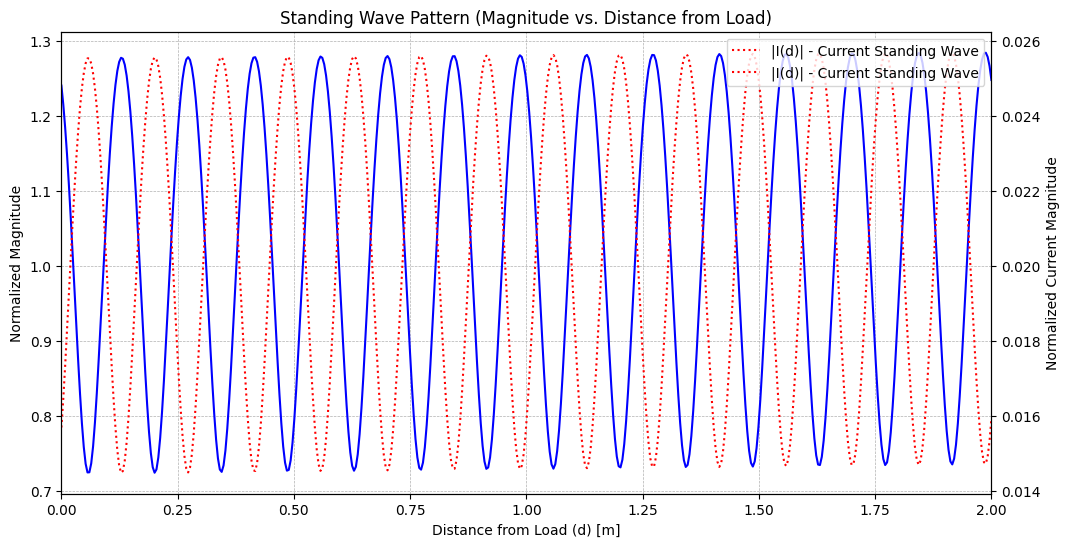

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==============================================================================
# STEP 1: COMPLETE TRANSMISSION LINE CLASS DEFINITION
# ==============================================================================
class TransmissionLine:
    """
    A class to model a general transmission line for parameter calculation.
    """
    def __init__(self, R, L, G, C, freq, length, ZL):
        # --- Primary Constants and Operating Conditions ---
        self.R = R
        self.L = L
        self.G = G
        self.C = C
        self.freq = freq
        self.length = length
        self.ZL = complex(ZL)

        # --- Derived values ---
        self.omega = 2 * np.pi * self.freq

        # --- Calculate all secondary parameters on initialization ---
        self._calculate_secondary_constants()
        self.gamma_L = self.calculate_reflection_coefficient()
        self.swr = self.calculate_swr()
        self.Z_in = self.calculate_input_impedance()

    def _calculate_secondary_constants(self):
        """Calculates Z0 (Characteristic Impedance) and gamma (Propagation Constant)."""
        Z_jwL = self.R + 1j * self.omega * self.L
        Y_jwC = self.G + 1j * self.omega * self.C
        if Y_jwC == 0:
            raise ValueError("Conductance (G) and Capacitance (C) cannot both be zero.")
        self.Z0 = np.sqrt(Z_jwL / Y_jwC)
        self.gamma = np.sqrt(Z_jwL * Y_jwC)
        self.alpha = self.gamma.real
        self.beta = self.gamma.imag

    def calculate_reflection_coefficient(self):
        """Calculates the load reflection coefficient."""
        return (self.ZL - self.Z0) / (self.ZL + self.Z0)

    def calculate_swr(self):
        """Calculates the Standing Wave Ratio (SWR)."""
        mag_gamma_L = np.abs(self.gamma_L)
        if np.isclose(mag_gamma_L, 1.0):
            return np.inf
        return (1 + mag_gamma_L) / (1 - mag_gamma_L)

    def calculate_input_impedance(self):
        """Calculates the input impedance of the line."""
        numerator = self.ZL + self.Z0 * np.tanh(self.gamma * self.length)
        denominator = self.Z0 + self.ZL * np.tanh(self.gamma * self.length)
        return self.Z0 * (numerator / denominator)

    def get_voltage_and_current(self, d):
        """
        Calculates normalized voltage and current at a distance 'd' from the load.
        Assumes incident voltage V0+ is 1 for normalization.
        """
        Vd = np.exp(self.gamma * d) + self.gamma_L * np.exp(-self.gamma * d)
        Id = (1 / self.Z0) * (np.exp(self.gamma * d) - self.gamma_L * np.exp(-self.gamma * d))
        return Vd, Id

    def display_voltage_and_current_at_point(self, d):
        """
        Calculates and prints the voltage and current at a specific distance 'd' from the load.
        """
        if d > self.length or d < 0:
            print(f"Error: Distance {d}m is outside the line length of {self.length}m.")
            return

        Vd, Id = self.get_voltage_and_current(d)
        print(f"\n--- Values at {d} meters from the load ---")
        print(f"Normalized Voltage (Vd): {Vd:.3f}")
        print(f"  - Magnitude: {np.abs(Vd):.3f} V")
        print(f"  - Phase: {np.angle(Vd, deg=True):.2f} degrees")
        print(f"Normalized Current (Id): {Id:.3f} A")
        print(f"  - Magnitude: {np.abs(Id):.3f} A")
        print(f"  - Phase: {np.angle(Id, deg=True):.2f} degrees")
        print("------------------------------------------")

    def plot_waveforms(self):
        """
        Calculates and plots the voltage and current standing wave patterns.
        """
        d_space = np.linspace(0, self.length, 500) # Distance from load
        V_mag = np.zeros(len(d_space))
        I_mag = np.zeros(len(d_space))

        for i, d in enumerate(d_space):
            Vd, Id = self.get_voltage_and_current(d)
            V_mag[i] = np.abs(Vd)
            I_mag[i] = np.abs(Id)

        plt.figure(figsize=(12, 6))
        plt.plot(d_space, V_mag, label='|V(d)| - Voltage Standing Wave', color='blue')
        plt.title('Standing Wave Pattern (Magnitude vs. Distance from Load)')
        plt.xlabel('Distance from Load (d) [m]')
        plt.ylabel('Normalized Magnitude')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)

        # Add a second y-axis for the current
        ax2 = plt.gca().twinx()
        ax2.plot(d_space, I_mag, label='|I(d)| - Current Standing Wave', color='red', linestyle=':')
        ax2.set_ylabel('Normalized Current Magnitude')

        # Combine legends from both axes
        lines, labels = plt.gca().get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper right')

        plt.xlim(0, self.length)
        print("Plot generated. Please close the plot window to continue.")


# ==============================================================================
# STEP 2: UPDATED ANALYSIS WINDOW
# ==============================================================================
def analysis_window(input_params, model, scaler_X, scaler_y):
    """
    Takes a dictionary of line parameters, predicts performance metrics,
    analyzes V & I at a point, and plots the standing wave pattern.
    """
    print("\n--- Final Design and Analysis Window ---")

    # 1. Analytical Calculation (Ground Truth)
    print("\n[1] ANALYTICAL RESULTS")
    # The analytical calculation needs the complex ZL
    analytical_params = {k: v for k, v in input_params.items() if k not in ['ZL_real', 'ZL_imag', 'distance']}
    analytical_params['ZL'] = input_params['ZL_real'] + 1j * input_params['ZL_imag']

    line = TransmissionLine(**analytical_params)
    print(f"  - Characteristic Impedance (Z0): {line.Z0:.2f} Ω")
    print(f"  - Attenuation Constant (α): {line.alpha:.4f} Np/m")
    print(f"  - Phase Constant (β): {line.beta:.4f} rad/m")
    print(f"  - Reflection Coefficient (ΓL): {line.gamma_L:.3f}")
    print(f"  - SWR: {line.swr:.3f}")
    print(f"  - Input Impedance (Z_in): {line.Z_in:.2f} Ω")
    print("------------------------------------------")

    # 2. Machine Learning Prediction
    print("\n[2] MACHINE LEARNING PREDICTION")
    input_df = pd.DataFrame([input_params])
    # The model expects features in the same order as during training
    features = ['R', 'L', 'G', 'C', 'freq', 'length', 'ZL_real', 'ZL_imag', 'distance']
    input_features = input_df[features]
    input_scaled = scaler_X.transform(input_features)
    pred_scaled = model.predict(input_scaled)
    pred_real = scaler_y.inverse_transform(pred_scaled)[0]

    # The targets are whatever your model was trained to predict
    targets = ['Z0_real', 'Z0_imag', 'alpha', 'beta', 'SWR', 'Zin_real', 'Zin_imag'] # Example targets
    results = dict(zip(targets, pred_real))

    print(f"  - Predicted Z0: {results.get('Z0_real', 0):.2f} + {results.get('Z0_imag', 0):.2f}j Ω")
    print(f"  - Predicted α: {results.get('alpha', 0):.4f} Np/m")
    print(f"  - Predicted β: {results.get('beta', 0):.4f} rad/m")
    print(f"  - Predicted SWR: {results.get('SWR', 0):.3f}")
    print(f"  - Predicted Z_in: {results.get('Zin_real', 0):.2f} + {results.get('Zin_imag', 0):.2f}j Ω")
    print("------------------------------------------")

    # 3. Display V & I at a specific point (using the analytical object)
    print("\n[3] VOLTAGE & CURRENT AT A SPECIFIC POINT (Analytical)")
    try:
        dist_input_str = input("Enter a distance 'd' from the load (in meters) to analyze: ")
        dist_input = float(dist_input_str)
        line.display_voltage_and_current_at_point(dist_input)
    except (ValueError, TypeError):
        print("Invalid input. Please enter a number. Skipping point analysis.")

    # 4. Plotting the standing wave pattern (using the analytical object)
    print("\n[4] STANDING WAVE PATTERN (Analytical)")
    line.plot_waveforms()
    plt.show()

# ==============================================================================
# STEP 3: EXAMPLE USAGE (MOCK MODEL AND SCALERS)
# ==============================================================================
if __name__ == '__main__':
    # This is a dummy setup to make the analysis_window function runnable.
    # In your actual code, you would use your real, trained model and scalers.
    from sklearn.preprocessing import StandardScaler
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import train_test_split

    # Create some dummy data to fit the model and scalers
    # This mimics the structure of your real data
    num_samples = 100
    X_dummy = pd.DataFrame({
        'R': np.random.rand(num_samples), 'L': np.random.rand(num_samples),
        'G': np.random.rand(num_samples), 'C': np.random.rand(num_samples),
        'freq': np.random.rand(num_samples) * 1e9, 'length': np.random.rand(num_samples) * 10,
        'ZL_real': np.random.rand(num_samples) * 100, 'ZL_imag': np.random.rand(num_samples) * 100,
        'distance': np.random.rand(num_samples) * 5
    })
    y_dummy = pd.DataFrame({
        'Z0_real': np.random.rand(num_samples) * 50, 'Z0_imag': np.random.rand(num_samples) * -10,
        'alpha': np.random.rand(num_samples) * 0.1, 'beta': np.random.rand(num_samples) * 10,
        'SWR': np.random.rand(num_samples) * 5 + 1, 'Zin_real': np.random.rand(num_samples) * 100,
        'Zin_imag': np.random.rand(num_samples) * 100
    })

    # Fit mock scalers
    mock_scaler_X = StandardScaler().fit(X_dummy)
    mock_scaler_y = StandardScaler().fit(y_dummy)

    # Fit a mock model
    mock_model = RandomForestRegressor(n_estimators=10, random_state=42)
    mock_model.fit(mock_scaler_X.transform(X_dummy), mock_scaler_y.transform(y_dummy))
    print("--- Mock Model and Scalers are ready for demonstration ---")

    # Define a set of input parameters for a hypothetical transmission line
    test_params = {
        'R': 0.5,           # Resistance (Ohm/m)
        'L': 250e-9,        # Inductance (H/m)
        'G': 1e-6,          # Conductance (S/m)
        'C': 100e-12,       # Capacitance (F/m)
        'freq': 700e6,      # Frequency (Hz) -> 700 MHz
        'length': 2.0,      # Length (m)
        'ZL_real': 75.0,    # Load Impedance (Real part)
        'ZL_imag': -25.0,   # Load Impedance (Imaginary part)
        'distance': 0.5     # A dummy distance value needed for the model input shape
    }

    # Run the analysis
    analysis_window(test_params, mock_model, mock_scaler_X, mock_scaler_y)